In [19]:
import pandas as pd
import sys
from pandas_datareader import data as pdr
from pandas import tseries
#!{sys.executable} -m pip install pandas_datareader
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 6))
pd.options.display.max_rows = 10

# get current data for Intel Corporation 

#priceINTC = pd.DataFrame(yf.download("", start="2011-01-01")['Adj Close'])
%matplotlib inline
plt.style.use('ggplot')

In [4]:
px = yf.download("INTC", start="2011-01-01")['Adj Close']

[*********************100%***********************]  1 of 1 downloaded


In [5]:
px.head(8)

Date
2011-01-03    16.272518
2011-01-04    16.506655
2011-01-05    16.342758
2011-01-06    16.210083
2011-01-07    16.124228
2011-01-10    16.147652
2011-01-11    16.428610
2011-01-12    16.623720
Name: Adj Close, dtype: float64

In [6]:
expiry = {'ESU2': datetime(2012, 9, 21),
          'ESZ2': datetime(2012, 12, 21)}
expiry = pd.Series(expiry).sort_values()
expiry

ESU2   2012-09-21
ESZ2   2012-12-21
dtype: datetime64[ns]

In [7]:
np.random.seed(12347)
N = 200
walk = (np.random.randint(0, 200, size=N) - 100) * 0.25
perturb = (np.random.randint(0, 20, size=N) - 10) * 0.25
walk = walk.cumsum()

rng = pd.date_range(px.index[0], periods=len(px) + N, freq='B')
near = np.concatenate([px.values, px.values[-1] + walk])
far = np.concatenate([px.values, px.values[-1] + walk + perturb])
prices = pd.DataFrame({'ESU2': near, 'ESZ2': far}, index=rng)

In [8]:
prices.tail()

,ESU2,ESZ2
2019-03-15,75.91,77.66
2019-03-18,62.16,64.41
2019-03-19,70.16,71.91
2019-03-20,86.66,85.91
2019-03-21,66.66,64.41


In [9]:
def get_roll_weights(start, expiry, items, roll_periods=5):
    # start : first date to compute weighting DataFrame
    # expiry : Series of ticker -> expiration dates
    # items : sequence of contract names
    
    dates = pd.date_range(start, expiry[-1], freq='B')
        
    weights = pd.DataFrame(np.zeros((len(dates), len(items))),
                          index=dates, columns=items)
    prev_date = weights.index[0]
    for i, (item, ex_date) in enumerate(expiry.iteritems()):
        if i < len(expiry) - 1:
            weights.loc[prev_date:ex_date - pd.tseries.offsets.BDay(), item] = 1
            
            roll_rng = pd.date_range(end=ex_date - pd.offsets.BDay(),
                                     periods=roll_periods + 1, freq='B')                                   
            decay_weights = np.linspace(0, 1, roll_periods + 1)
            weights.loc[roll_rng, item] = 1 - decay_weights
            weights.loc[roll_rng, expiry.index[i + 1]] = decay_weights
    else:
            weights.loc[prev_date:, item] = 1
    prev_date = ex_date
    return weights

In [10]:
weights = get_roll_weights('6/1/2012', expiry, prices.columns)
weights.loc['2012-09-12':'2012-09-21']

,ESU2,ESZ2
2012-09-12,1.0,1.0
2012-09-13,1.0,1.0
2012-09-14,0.8,1.0
2012-09-17,0.6,1.0
2012-09-18,0.4,1.0
2012-09-19,0.2,1.0
2012-09-20,0.0,1.0
2012-09-21,0.0,1.0


In [11]:
rolled_returns = (prices.pct_change() * weights).sum(1)

In [12]:
rolled_returns.sample(8)

2018-08-16    0.000000
2012-09-28   -0.018459
2015-03-11    0.000000
2019-03-07    0.000000
2019-03-06    0.000000
2013-07-03    0.000000
2016-01-29    0.000000
2019-03-13    0.000000
dtype: float64

In [13]:
#Rolling correlation and linear regression

In [14]:
intel = yf.download("INTC", start="2016-01-01")['Adj Close']
amd = yf.download("AMD", start="2016-01-01")['Adj Close']

intel_rets = intel.pct_change()
amd_rets = amd.pct_change()

[*********************100%***********************]  1 of 1 downloaded


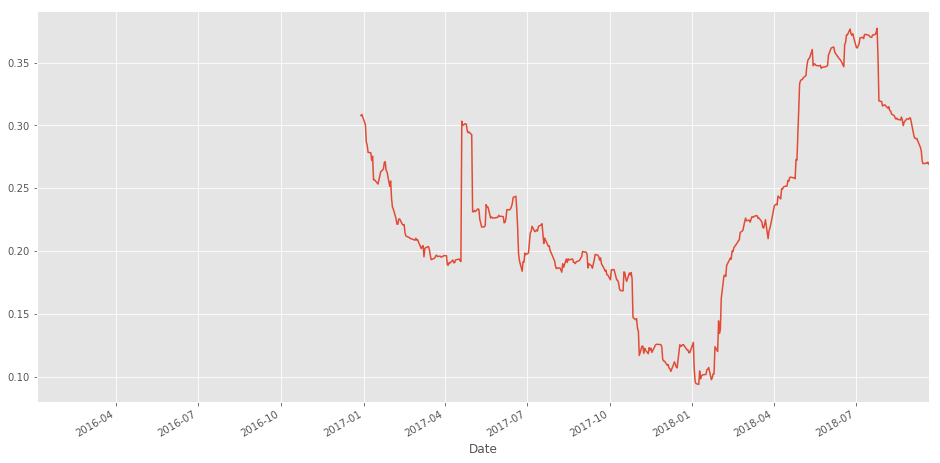

In [22]:
#corr = intel_rets.rolling(250).corr(amd_rets)
intel_rets.rolling(250).corr(amd_rets).plot(figsize=(16,8))
#corr.columns = ['Date', 'intel2amdCorr']
#corr.plot

In [30]:
from pyfinance.ols import PandasRollingOLS
model = PandasRollingOLS(y=amd_rets, x= intel_rets, window=250)
model.beta

ModuleNotFoundError: No module named 'pyfinance'

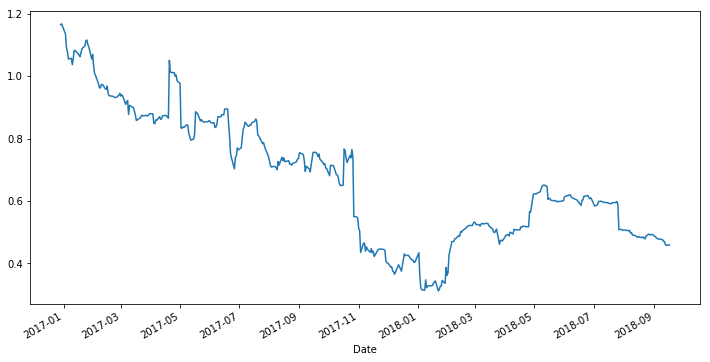

In [242]:
model.beta['feature1'].plot()

In [243]:
intel_rets

Date
2016-01-04         NaN
2016-01-05   -0.004707
2016-01-06   -0.022170
2016-01-07   -0.037485
2016-01-08   -0.010364
                ...   
2018-09-11   -0.029590
2018-09-12    0.000000
2018-09-13    0.014244
2018-09-14   -0.000658
2018-09-17   -0.001537
Name: Adj Close, Length: 682, dtype: float64

In [244]:
amd_rets

Date
2016-01-04         NaN
2016-01-05   -0.007220
2016-01-06   -0.087273
2016-01-07   -0.091633
2016-01-08   -0.061404
                ...   
2018-09-11    0.007026
2018-09-12    0.070100
2018-09-13   -0.053710
2018-09-14    0.073491
2018-09-17   -0.014976
Name: Adj Close, Length: 682, dtype: float64